# Imports

In [1]:
import glob
import matplotlib.image as mpimg
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage.measurements import label
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import random
%matplotlib inline

# Functions for extracting Features

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        if spatial_feat == True:
            #Compute binned color features  
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

# Functions for finding cars in an image and applying heating boxes

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**1
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # List of all bounding boxes
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Pipeline

In [4]:
def process_img(img):
    #net_heat_threshold = 1
    global global_box_list
    global global_last_labels
    global global_frame_counter
    
    if (global_frame_counter % 5 == 0):
        frame_box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        global_box_list.append(frame_box_list)
    
        # Create the heatmap image
        heat = np.zeros_like(img[:,:,0]).astype(np.float)    
        heat = add_heat(heat, [bbox for frame_box_list in global_box_list for bbox in frame_box_list])

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,5)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        img_labels = draw_labeled_bboxes(np.copy(img), labels)
        global_last_labels = labels
    else:
        img_labels = draw_labeled_bboxes(np.copy(img), global_last_labels)
    
    global_frame_counter +=1
    return img_labels

# Other functions

In [5]:
def plt_compare(img1, img2, title1 = 'Original Image', title2 = 'Processed Image', cmap_in = None, cmap_out = None, figsize = (25,15)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    f.tight_layout()
    ax1.imshow(img1, cmap = cmap_in)
    ax1.set_title(title1, fontsize=15)
    ax2.imshow(img2, cmap = cmap_out)
    ax2.set_title(title2, fontsize=15)
    return 

def plt_compare3(img1, img2, img3,title1='', title2='',title3='', cmap1 = None, cmap2 = None, cmap3 = None, figsize = (40,15)):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = figsize)
    f.tight_layout()
    ax1.imshow(img1, cmap = cmap1)
    ax1.set_title(title1, fontsize=25)
    ax2.imshow(img2, cmap = cmap2)
    ax2.set_title(title2, fontsize=25)
    ax3.imshow(img3, cmap = cmap3)
    ax3.set_title(title3, fontsize=25)
    return 


    # Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list



# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

# VEHICLE DETECTION

# Parameter Setting

In [6]:
debug = 1
balance = 0 
# First of all we must train a classifier

# Read images 

vehicles = glob.glob('./training_images/vehicles/*/*.png')
non_vehicles = glob.glob('./training_images/non-vehicles/*/*.png')

if debug:
    print("Vehicle images no: ",len(vehicles))
    print("Non-vehicle images no: ",len(non_vehicles))

if balance:
    # "Balance" the set, by using the same ammount of images of each label
    sample_size = min(len(vehicles), len(non_vehicles))
    vehicles = vehicles[0:sample_size]
    non_vehicles = non_vehicles[0:sample_size]
    print(" No of samples used: ", sample_size)


# Set parameters for feature extraction

# Colorspace to extract feature from
#Colorspace options: RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb'
# Spatial Binning of Color, default = (32,32)
spatial_size = (32,32)
# Histogram bins, default = 32
hist_bins = 32
# HOG orientations, default=9
orient = 9
# HOG pixels per cell, default = 8
pix_per_cell = 8
# HOG cells per block, default = 2
cell_per_block = 2
# HOG channel no to extract features, options: 0,1,2,'ALL', default = 0
hog_channel = 'ALL'
# Use Spatial features, default = True
spatial_feat = True
# Use Histogram features, default = True
hist_feat = True
# Use HOG features, default = True
hog_feat = True


Vehicle images no:  8792
Non-vehicle images no:  8968


# Extract the features of car and non car objects

In [7]:
if debug: t=time.time()
car_features = extract_features(vehicles, color_space=color_space, spatial_size=spatial_size,
                                    hist_bins=hist_bins, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(non_vehicles, color_space=color_space, spatial_size=spatial_size,
                                    hist_bins=hist_bins, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

if debug:
    t2 = time.time()
    print("Features Extracted! Time to extract: {} Seconds".format(round(t2-t, 2)))

Features Extracted! Time to extract: 83.24 Seconds


# Prepare the Training and Test Set

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of: {} histogram bins {}, orientations of {} and {}  pixels per cell with {} cells per block '.format(
    spatial_size, hist_bins,orient,pix_per_cell,cell_per_block))
      
print('Feature vector length: {}'.format(len(X_train[0])))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('{} Seconds to train SVC Model'.format(round(t2-t, 2)))

# Check the score of the SVC
print('Test Accuracy of SVC = {}'.format(round(svc.score(X_test, y_test), 4)))

# Check the prediction time for 10 samples
t=time.time()
n_predict = 10

print('My SVC predicts: {}'.format(svc.predict(X_test[0:n_predict])))
print('For these {} labels:{} '.format(n_predict,y_test[0:n_predict]))
t2 = time.time()
print('{} Seconds to predict {} labels with SVC'.format(round(t2-t, 5),n_predict))

Using spatial binning of: (32, 32) histogram bins 32, orientations of 9 and 8  pixels per cell with 2 cells per block 
Feature vector length: 8460
11.54 Seconds to train SVC Model
Test Accuracy of SVC = 0.9904
My SVC predicts: [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:[ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.] 
0.001 Seconds to predict 10 labels with SVC


# TEST IMAGES

## HOG Visualization

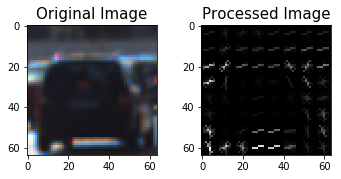

In [9]:
img_random_vehicle =  mpimg.imread(random.choice(vehicles))
_, img_random_vehicle_hog = get_hog_features(cv2.cvtColor(img_random_vehicle, cv2.COLOR_RGB2GRAY), orient,
                                             pix_per_cell, cell_per_block, vis = True)

a = plt_compare(img_random_vehicle, img_random_vehicle_hog, cmap_out = 'gray', figsize = (5,3))

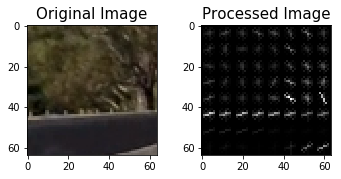

In [10]:
img_random_non_vehicle = mpimg.imread(random.choice(non_vehicles))
_, img_random_non_vehicle_hog = get_hog_features(cv2.cvtColor(img_random_non_vehicle, cv2.COLOR_RGB2GRAY), orient,
                                             pix_per_cell, cell_per_block, vis = True)

a = plt_compare(img_random_non_vehicle, img_random_non_vehicle_hog, cmap_out = 'gray', figsize = (5,3))

## Draw the windows that are used in the search

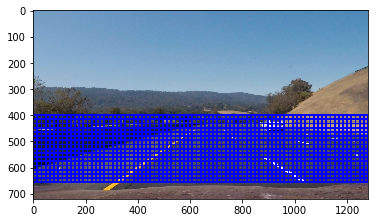

In [11]:
path = "./test_images/test3.jpg"
image = image = mpimg.imread(path)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 660], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
result = draw_boxes(image, windows)

plt.imshow(result)
plt.show()

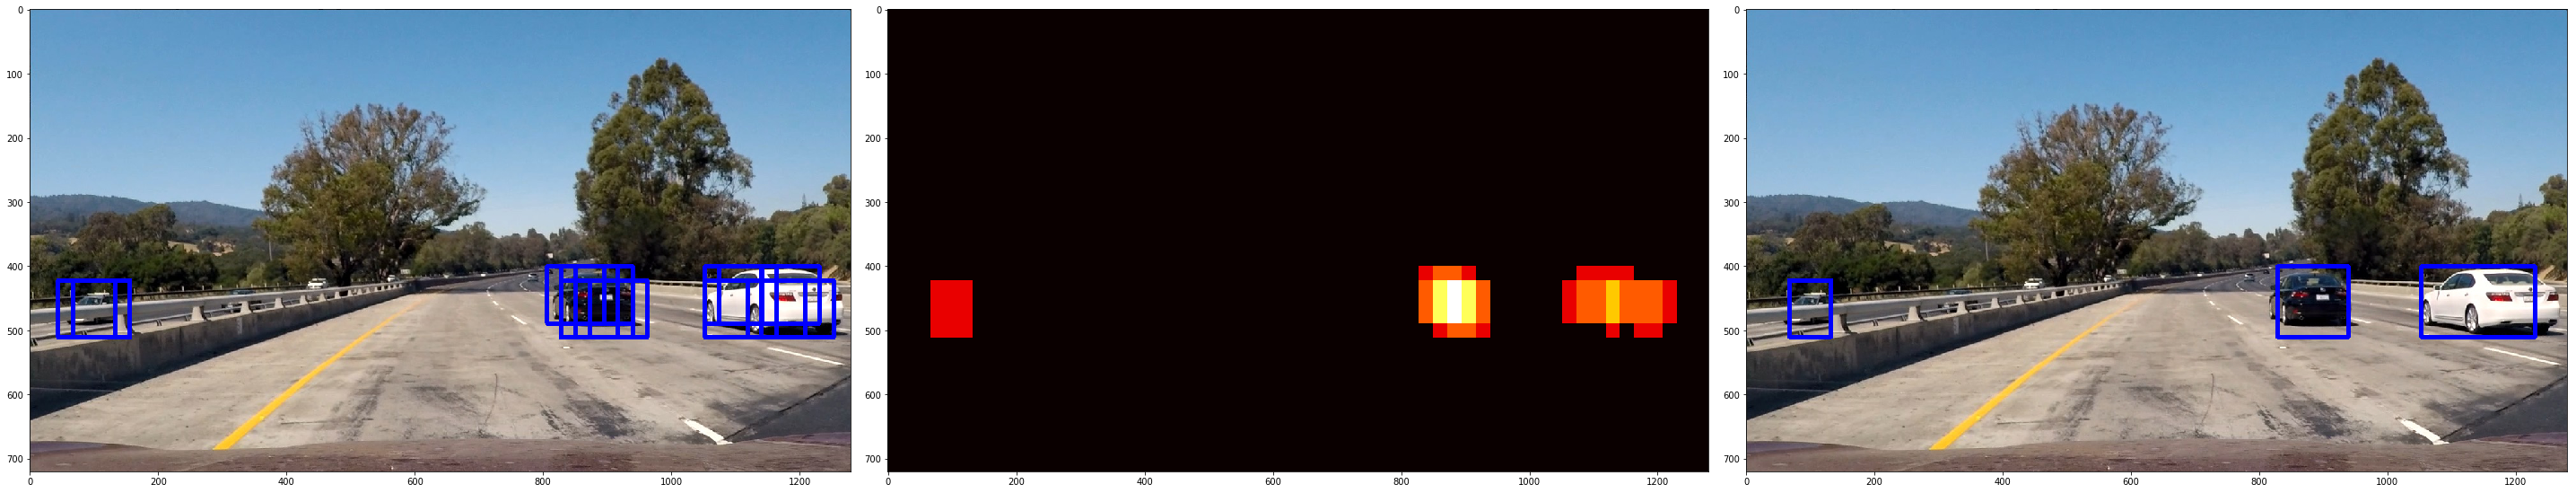

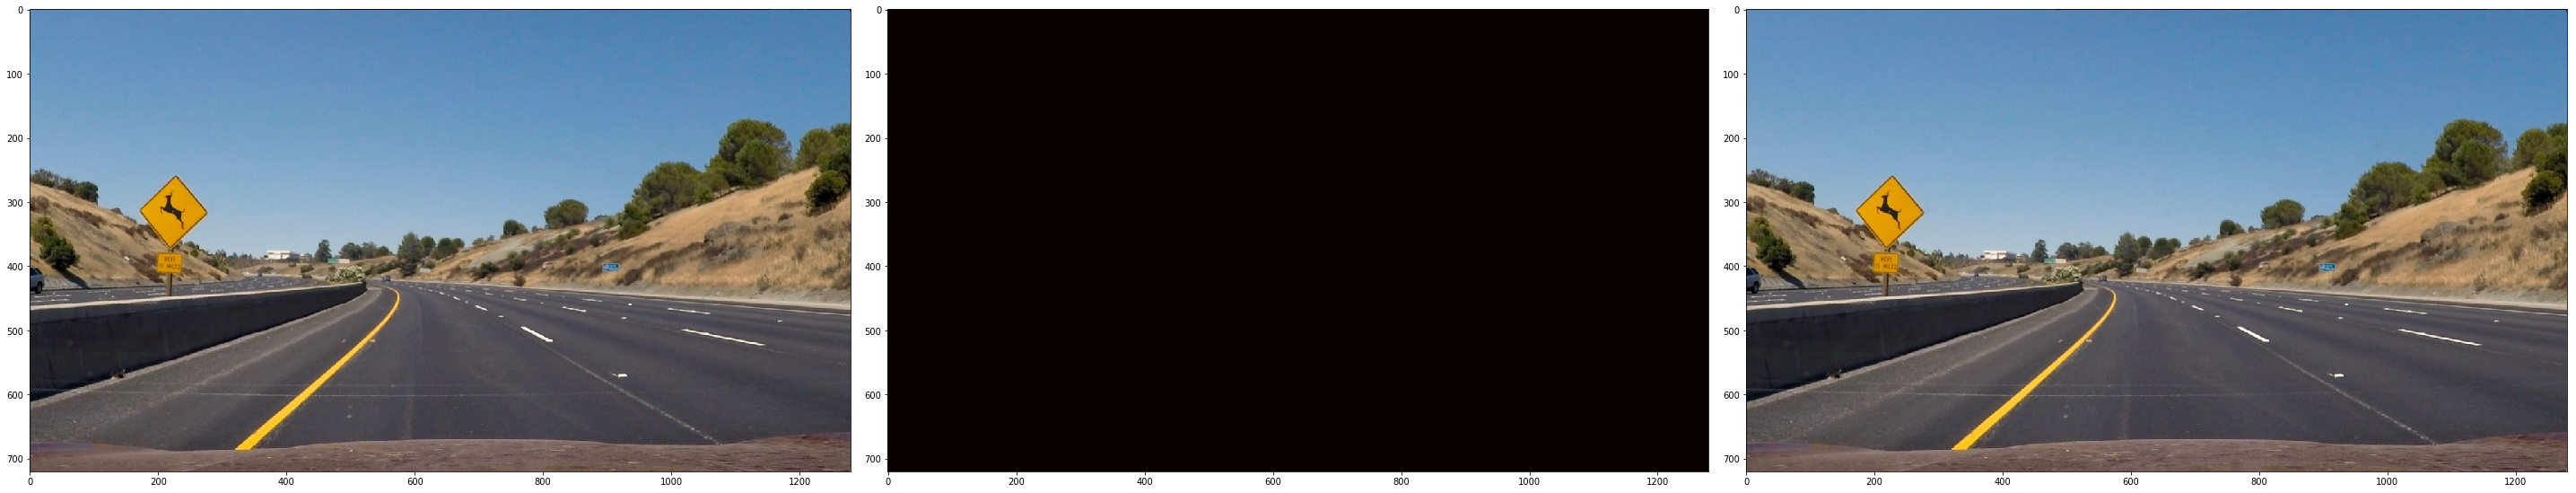

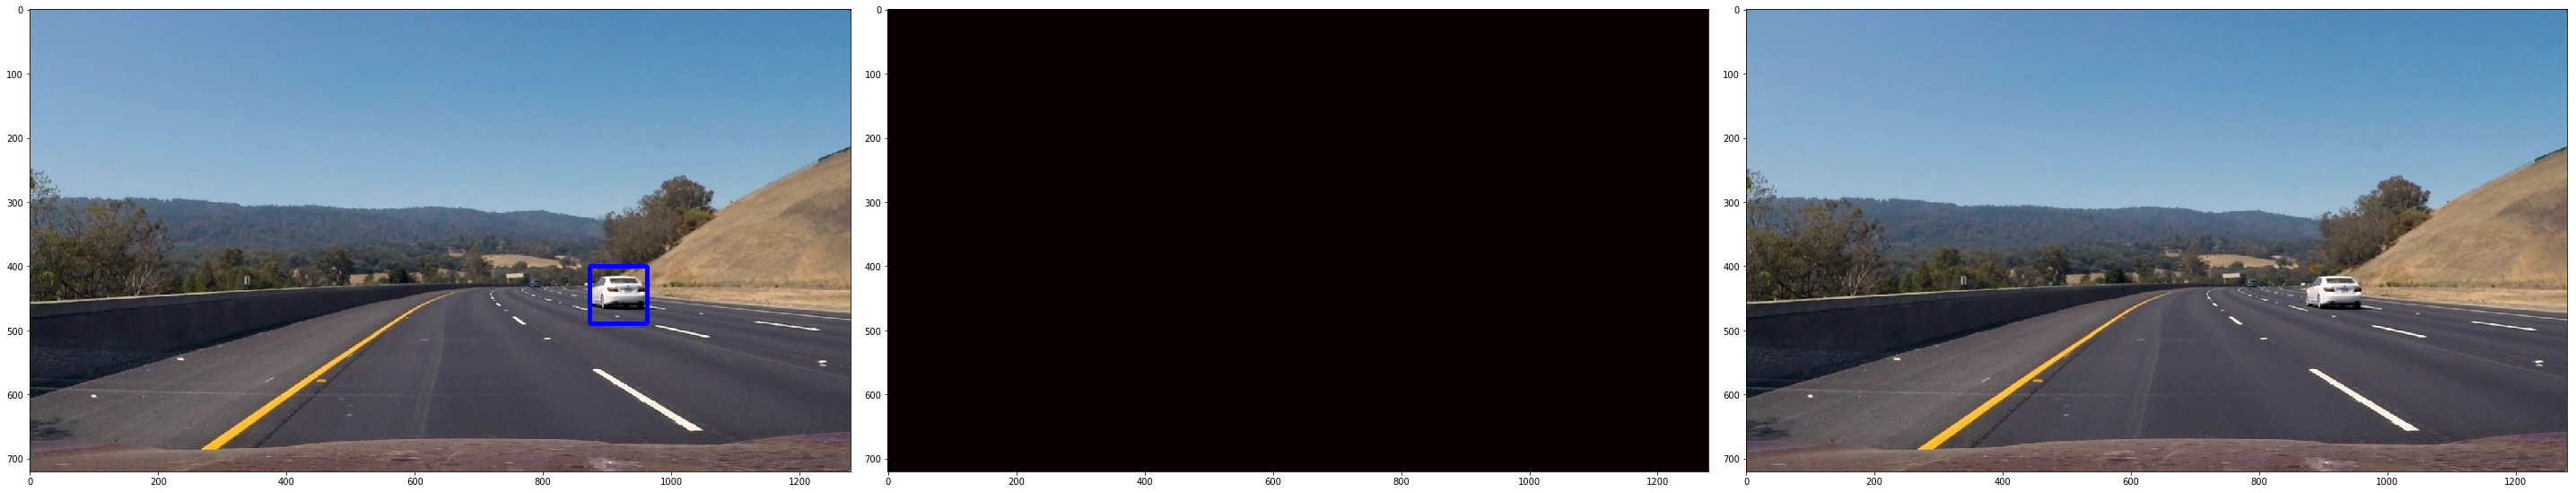

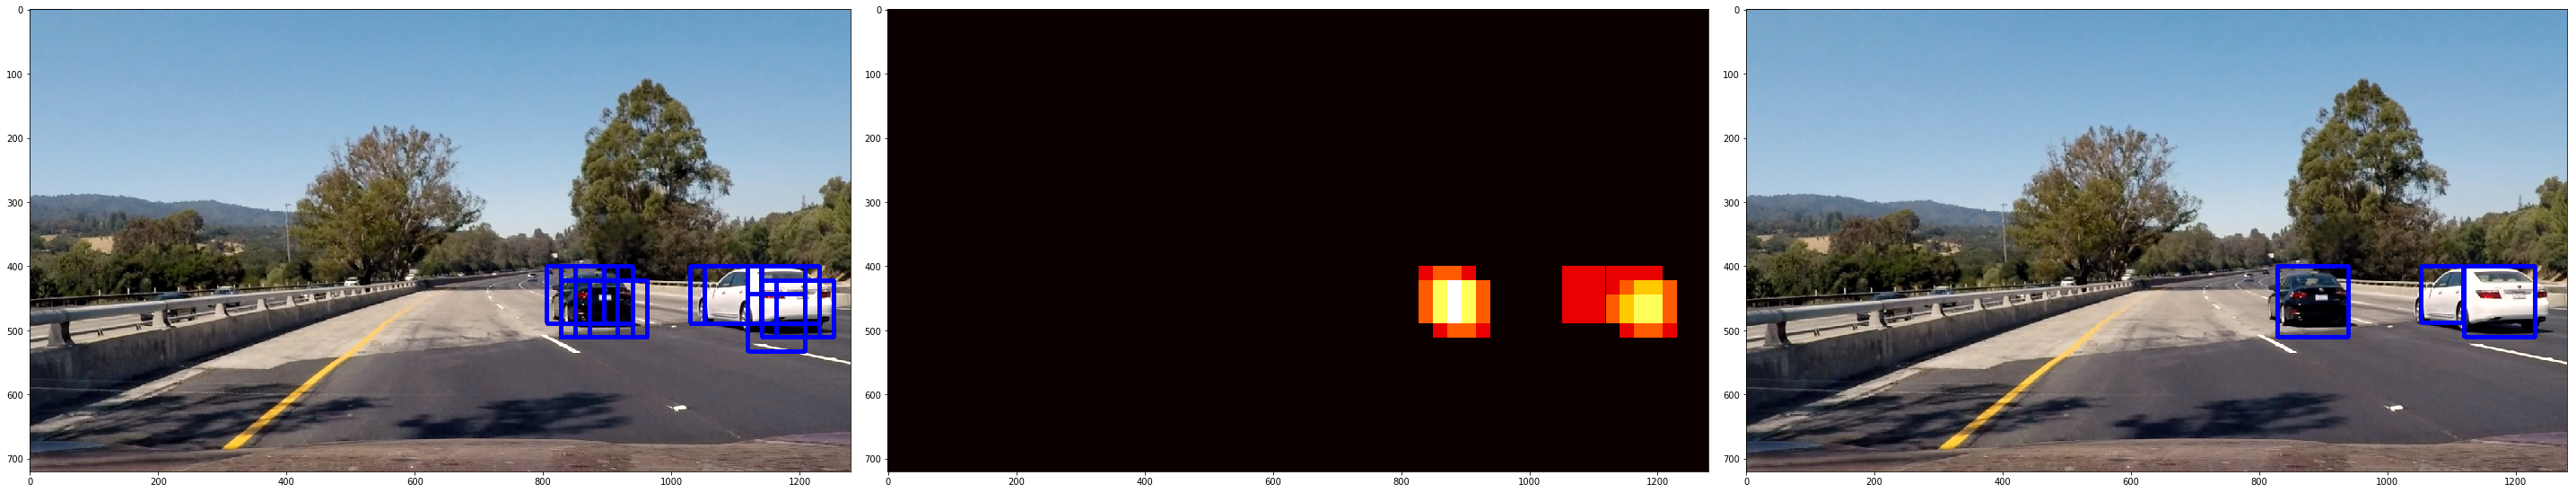

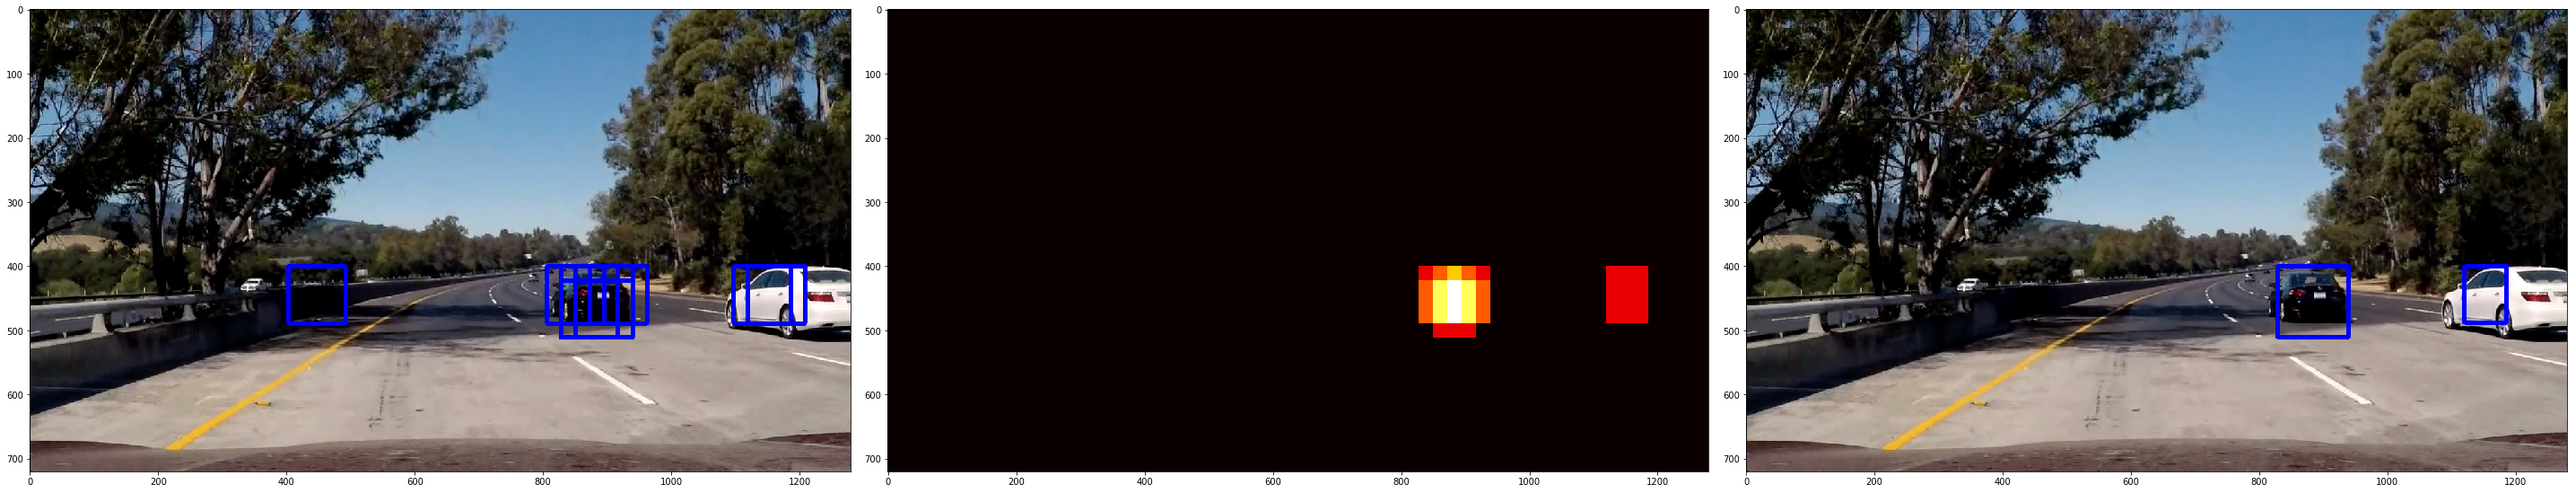

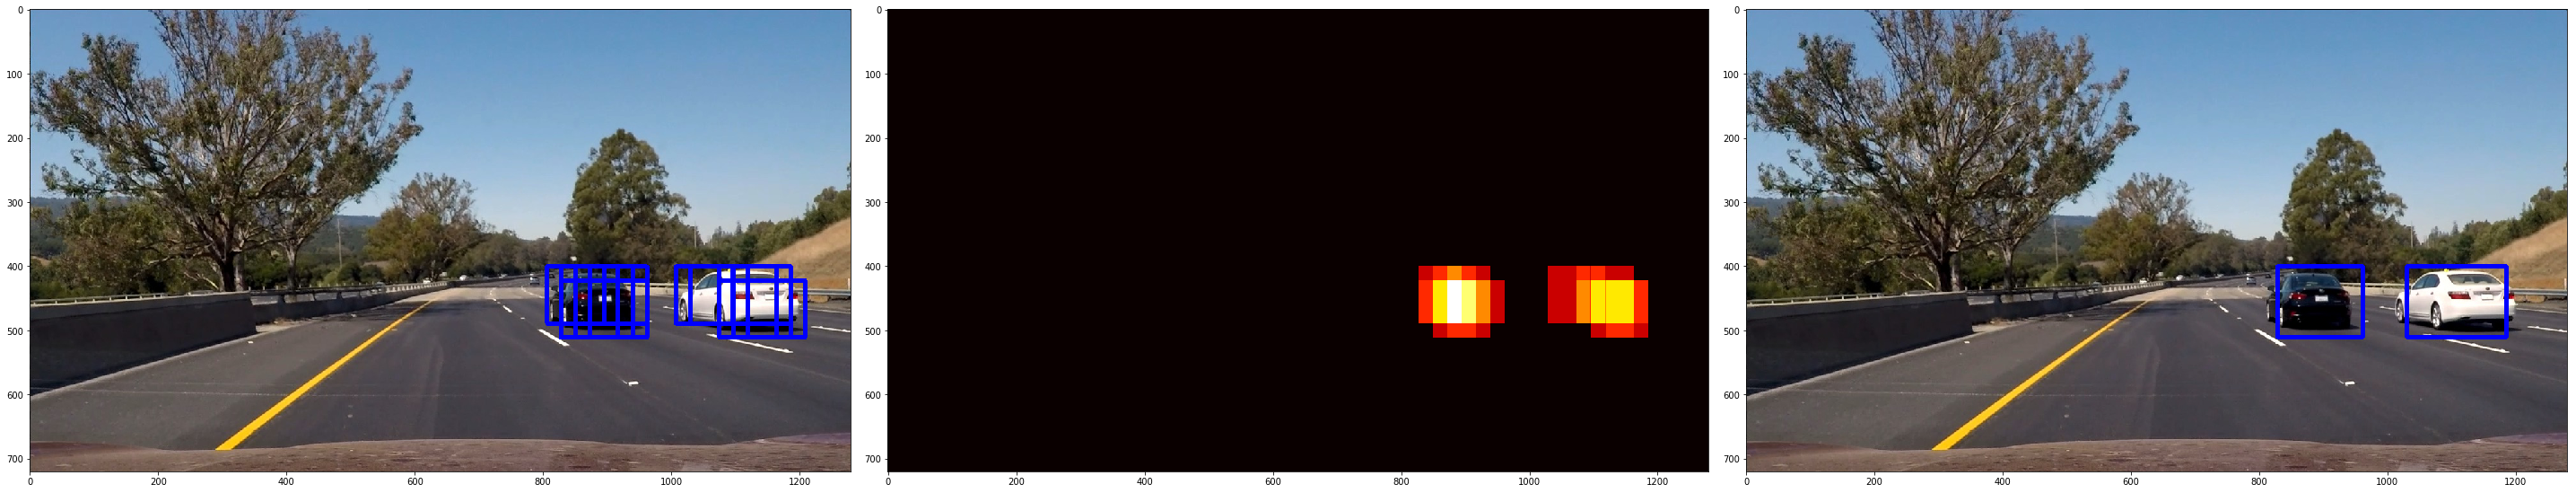

In [12]:
global_box_list = deque(maxlen = 1)
ystart = 400
#ystop = 660
ystop = 660
scale = 1.4
debug = 1

global_box_list = deque(maxlen = 1)
imgs = glob.glob('./test_images/*.jpg')
for file in imgs:
        img = mpimg.imread(file)
        frame_box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,frame_box_list)

        #plt.imshow(out_img)
        #plt.show()
        heat = apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #tmp_img = np.zeros_like(img[:,:,:]).astype(np.uint8)
        #tmp_img[:,:,"]
        img_labels = draw_labeled_bboxes(np.copy(img), labels)
        img_framebox_list = draw_boxes(img, frame_box_list)

        if debug:
            plt_compare3(img_framebox_list,heatmap,img_labels, cmap2='hot')



In [13]:
from moviepy.editor import VideoFileClip
global_box_list = deque(maxlen = 10)
global_frame_counter = 0
global_last_labels = []
ystart = 400
ystop = 660
scale = 1.4
debug = 0



project_output_file = "project_output5.mp4"
project_video1 = VideoFileClip("project_video.mp4")

project_output = project_video1.fl_image(process_img)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output5.mp4
[MoviePy] Writing video project_output5.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:44<00:00, 12.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output5.mp4 

Wall time: 1min 45s
